In [9]:
!nvidia-smi  --query-gpu=name,memory.total,memory.used --format=csv,noheader

NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188 MiB, 92 MiB


In [ ]:
Coded by B.Heddle, E. Porter and N. Wong

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

Label_encoder = LabelEncoder()

In [11]:
# Load the train data_trainset
data_train = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)

#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_train['gender'] = data_train['gender'].map(gender_conversion)

data_train['name'] = data_train['first'] + " " + data_train['last']
data_train['address'] = data_train['street'] + ", " + data_train['city'] + ", " + data_train['state']

#Convert first name
data_train['first#'] = Label_encoder.fit_transform(data_train['first'])

#Convert last  name
data_train['last#'] = Label_encoder.fit_transform(data_train['last'])

#Convert first name + last name
data_train['name#'] = Label_encoder.fit_transform(data_train['name'])

#data_train['age'] = 2024 - pd.to_numeric(data_train['dob'].str[:4]) 

#Convert Job
data_train['job#'] = Label_encoder.fit_transform(data_train['job'])

data_train['merchant#'] = Label_encoder.fit_transform(data_train['merchant'])

data_train['category#'] = Label_encoder.fit_transform(data_train['category'])


data_train['street#'] = Label_encoder.fit_transform(data_train['street'])
data_train['city#'] = Label_encoder.fit_transform(data_train['city'])
data_train['state#'] = Label_encoder.fit_transform(data_train['state'])

data_train['address#'] = Label_encoder.fit_transform(data_train['address'])

data_train['trans_num'] = Label_encoder.fit_transform(data_train['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_train['age'] = data_train['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_train['distance_km'] = haversine(data_train['lat'], data_train['long'], data_train['merch_lat'], data_train['merch_long'])


#data_train = data_train.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])
data_train = data_train.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_train.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,name,address,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,98699,1371816865,33.986391,-81.200714,0,Jeff Elliott,"351 Darlene Green, Columbia, SC",151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",108785,1371816873,39.450498,-109.960431,0,Joanne Williams,"3638 Marsh Union, Altonah, UT",163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,0,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",433979,1371816893,40.495810,-74.196111,0,Ashley Lopez,"9333 Valentine Point, Bellmore, NY",24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,1,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,71993,1371816915,28.812398,-80.883061,0,Brian Williams,"32941 Krystal Mill Apt. 552, Titusville, FL",42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,1,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,190585,1371816917,44.959148,-85.884734,0,Nathan Massey,"5783 Evan Roads Apt. 465, Falmouth, MI",247,261,678,196,292,13,548,247,21,548,69,104.335106


In [12]:
# Load the test dataset
data_test = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)


#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_test['gender'] = data_test['gender'].map(gender_conversion)

data_test['name'] = data_test['first'] + " " + data_test['last']
data_test['address'] = data_test['street'] + ", " + data_test['city'] + ", " + data_test['state']

#Convert first name
data_test['first#'] = Label_encoder.fit_transform(data_test['first'])

#Convert last  name
data_test['last#'] = Label_encoder.fit_transform(data_test['last'])

#Convert first name + last name
data_test['name#'] = Label_encoder.fit_transform(data_test['name'])

#data_test['age'] = 2024 - pd.to_numeric(data_test['dob'].str[:4]) 

#Convert Job
data_test['job#'] = Label_encoder.fit_transform(data_test['job'])

data_test['merchant#'] = Label_encoder.fit_transform(data_test['merchant'])

data_test['category#'] = Label_encoder.fit_transform(data_test['category'])


data_test['street#'] = Label_encoder.fit_transform(data_test['street'])
data_test['city#'] = Label_encoder.fit_transform(data_test['city'])
data_test['state#'] = Label_encoder.fit_transform(data_test['state'])

data_test['address#'] = Label_encoder.fit_transform(data_test['address'])

data_test['trans_num'] = Label_encoder.fit_transform(data_test['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_test['age'] = data_test['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_test['distance_km'] = haversine(data_test['lat'], data_test['long'], data_test['merch_lat'], data_test['merch_long'])


#data_test = data_test.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])
data_test = data_test.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_test.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,name,address,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,98699,1371816865,33.986391,-81.200714,0,Jeff Elliott,"351 Darlene Green, Columbia, SC",151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",108785,1371816873,39.450498,-109.960431,0,Joanne Williams,"3638 Marsh Union, Altonah, UT",163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,0,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",433979,1371816893,40.495810,-74.196111,0,Ashley Lopez,"9333 Valentine Point, Bellmore, NY",24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,1,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,71993,1371816915,28.812398,-80.883061,0,Brian Williams,"32941 Krystal Mill Apt. 552, Titusville, FL",42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,1,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,190585,1371816917,44.959148,-85.884734,0,Nathan Massey,"5783 Evan Roads Apt. 465, Falmouth, MI",247,261,678,196,292,13,548,247,21,548,69,104.335106


In [13]:
X_train = data_train.drop(columns=['is_fraud'], axis=1)
y_train = data_train['is_fraud']

X_test = data_test.drop(columns=['is_fraud'], axis=1)
y_test = data_test['is_fraud']

# Identify numerical and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=5) #Depth = 2, 100 weak learners
model = AdaBoostClassifier(estimator=estimator, n_estimators=100, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 1.0
AUC Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       1.00      1.00      1.00      2145

    accuracy                           1.00    555719
   macro avg       1.00      1.00      1.00    555719
weighted avg       1.00      1.00      1.00    555719



In [14]:
# Create AdaBoost model -> depth = 1, weak learners = 100
estimator = DecisionTreeClassifier(max_depth=1)
model = AdaBoostClassifier(estimator=estimator, n_estimators=100, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9964244519262433
AUC Score: 0.9850622430855606

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.58      0.27      0.36      2145

    accuracy                           1.00    555719
   macro avg       0.79      0.63      0.68    555719
weighted avg       1.00      1.00      1.00    555719



In [15]:
# Create AdaBoost model -> depth = 2, weak learners = 100
estimator = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=estimator, n_estimators=100, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9984686505230161
AUC Score: 0.9990262340443166

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.87      0.71      0.78      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.85      0.89    555719
weighted avg       1.00      1.00      1.00    555719



In [16]:
# Create AdaBoost model -> depth = 2, weak learners = 200
estimator = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=estimator, n_estimators=200, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9990444811136564
AUC Score: 0.9997932704692776

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.82      0.87      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.91      0.93    555719
weighted avg       1.00      1.00      1.00    555719



In [17]:
# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=3)
model = AdaBoostClassifier(estimator=estimator, n_estimators=200, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9999730079410637
AUC Score: 0.9999998399887123

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       1.00      0.99      1.00      2145

    accuracy                           1.00    555719
   macro avg       1.00      1.00      1.00    555719
weighted avg       1.00      1.00      1.00    555719



In [18]:
# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=estimator, n_estimators=300, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9994331667623385
AUC Score: 0.9999413802858329

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.96      0.89      0.92      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.95      0.96    555719
weighted avg       1.00      1.00      1.00    555719



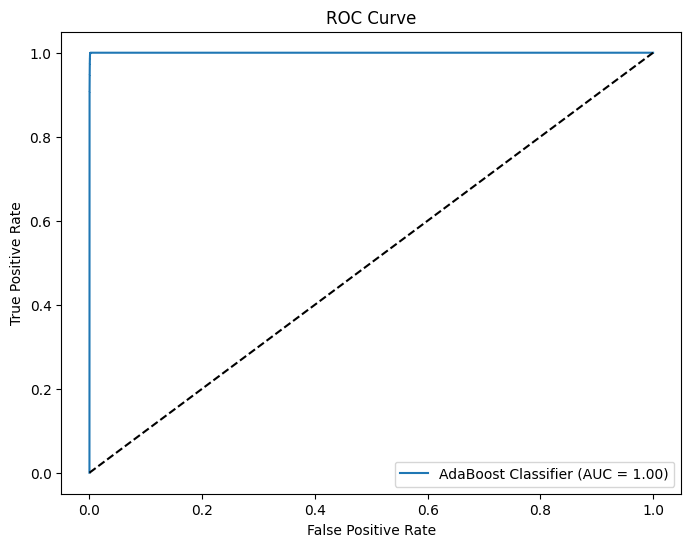

In [19]:

# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AdaBoost Classifier (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

        Feature  Total Importance
7     unix_time          0.133391
1           amt          0.100324
12     merchant          0.096861
14        first          0.094853
19          job          0.069085
15         last          0.062780
13     category          0.061908
16       street          0.039090
6      city_pop          0.036610
20         name          0.036003
21      address          0.033848
17         city          0.033793
10          age          0.032721
4           lat          0.031474
0        cc_num          0.027783
9    merch_long          0.022517
18        state          0.021513
11  distance_km          0.020040
3           zip          0.018973
5          long          0.012266
8     merch_lat          0.011404
2        gender          0.002764


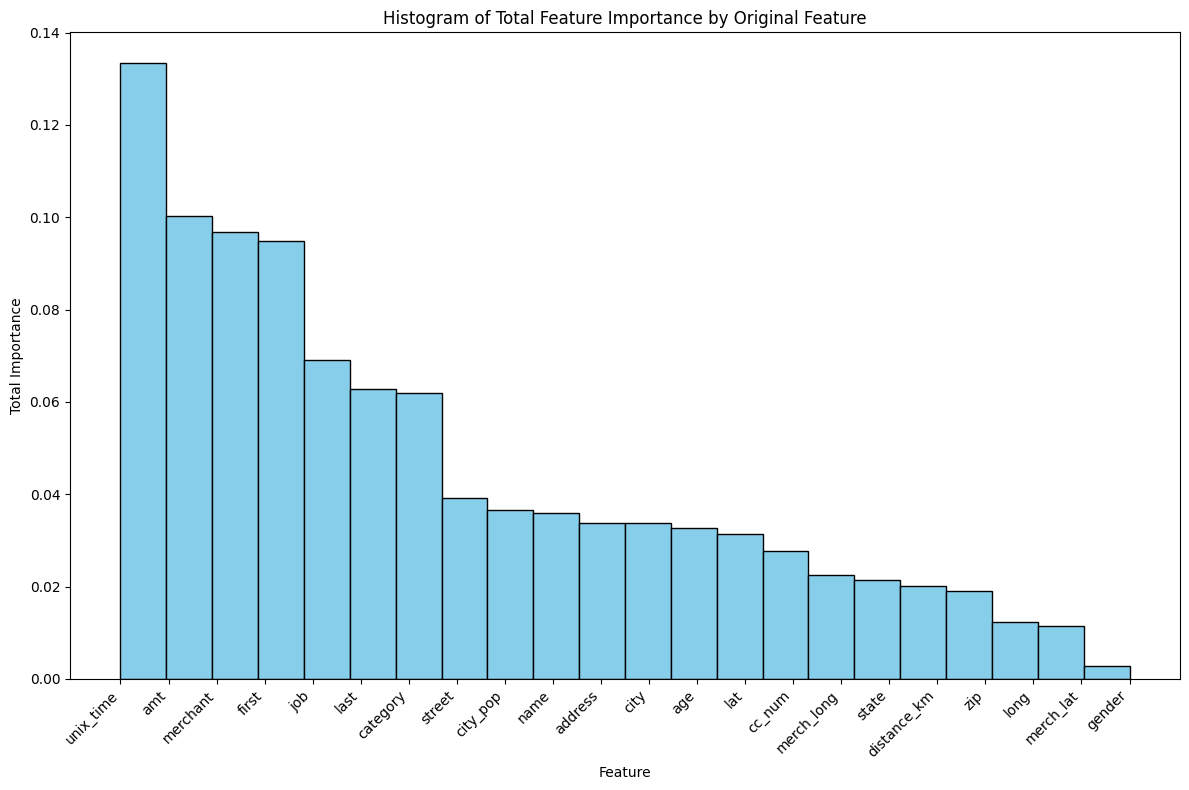

In [20]:
# Extract the model from the pipeline
adaboost_model = pipeline.named_steps['classifier']

# Get preprocessed feature names
onehot_categories = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
numeric_features_list = numeric_features.tolist()

# Combined feature names after preprocessing
all_feature_names = np.concatenate([numeric_features_list, onehot_categories])

# Feature importances from the AdaBoost model
feature_importances = adaboost_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sum feature importances by original feature
# Initialize a dictionary to store summed importances
feature_importance_summary = {}

# Sum importances for numeric features directly
for feature in numeric_features_list:
    feature_importance_summary[feature] = feature_importance_df.loc[
        feature_importance_df['Feature'] == feature, 'Importance'].sum()

# Sum importances for categorical features by grouping one-hot encoded columns
for original_feature in categorical_features:
    # Identify one-hot encoded columns for this original feature
    related_columns = [col for col in onehot_categories if col.startswith(original_feature)]
    # Sum their importances
    total_importance = feature_importance_df.loc[
        feature_importance_df['Feature'].isin(related_columns), 'Importance'].sum()
    feature_importance_summary[original_feature] = total_importance

# Create a DataFrame from the summary
importance_summary_df = pd.DataFrame(
    list(feature_importance_summary.items()),
    columns=['Feature', 'Total Importance']
).sort_values(by='Total Importance', ascending=False)

# Display the summary
print(importance_summary_df)

# Plotting the total importance as a histogram
plt.figure(figsize=(12, 8))
plt.hist(importance_summary_df['Feature'], weights=importance_summary_df['Total Importance'], bins=len(importance_summary_df), color='skyblue', edgecolor='black')
plt.xlabel('Feature')
plt.ylabel('Total Importance')
plt.title('Histogram of Total Feature Importance by Original Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

           Feature Type  Total Importance
0    Numerical Features          0.450267
1  Categorical Features          0.549733


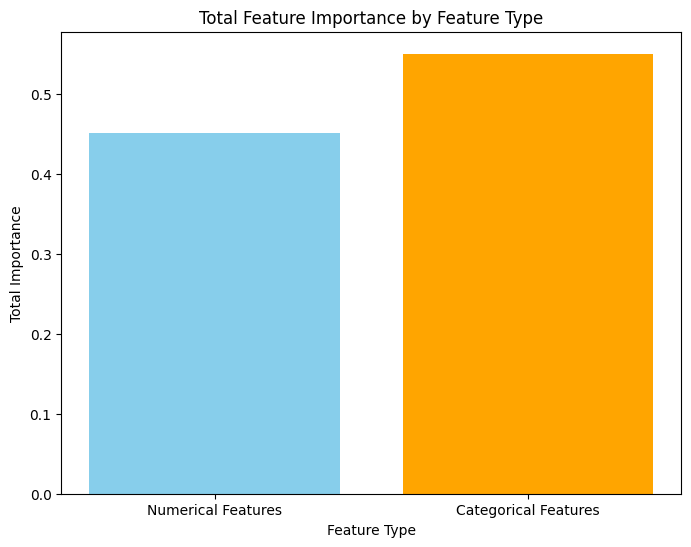

In [21]:

# Get preprocessed feature names
onehot_categories = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
numeric_features_list = numeric_features.tolist()

# Combined feature names after preprocessing
all_feature_names = np.concatenate([numeric_features_list, onehot_categories])

# Feature importances
feature_importances = adaboost_model.feature_importances_

# Create a DataFrame for analysis
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Separate numerical and categorical features
numeric_importance_total = feature_importance_df[feature_importance_df['Feature'].isin(numeric_features_list)]['Importance'].sum()
categorical_importance_total = feature_importance_df[feature_importance_df['Feature'].isin(onehot_categories)]['Importance'].sum()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Feature Type': ['Numerical Features', 'Categorical Features'],
    'Total Importance': [numeric_importance_total, categorical_importance_total]
})

# Display the summary
print(summary_df)

# Plot the total importance by feature type
plt.figure(figsize=(8, 6))
plt.bar(summary_df['Feature Type'], summary_df['Total Importance'], color=['skyblue', 'orange'])
plt.xlabel('Feature Type')
plt.ylabel('Total Importance')
plt.title('Total Feature Importance by Feature Type')
plt.show()